In [1]:
%load_ext autoreload
%autoreload 2

#import chainercv

In [2]:
from chainer.links.model.vision.vgg import VGG16Layers

predictor = VGG16Layers()

C:\Users\nakago\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Now loading caffemodel (usually it may take few minutes)


In [5]:
import numpy as np

import chainer
from chainer import cuda

device = 0 # set -1 for CPU

if device >= 0:
    chainer.cuda.get_device_from_id(device).use()  # Make a specified GPU current
    predictor.to_gpu()
    
xp = chainer.cuda.cupy if device >= 0 else np

In [6]:
import os
if not os.path.exists('imagenet1000_clsid_to_human.txt'):
    !wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt
else:
    print('already downloaded')

already downloaded


In [7]:
import numpy as np

with open('imagenet1000_clsid_to_human.txt') as f:
    lines = f.readlines()

    
def extract_value(s):
    quote_str = s[s.index(':') + 2]
    return s[s.find(quote_str)+1:s.rfind(quote_str)]

         
classes = np.array([extract_value(line) for line in lines])

In [8]:
classes

array(['tench, Tinca tinca', 'goldfish, Carassius auratus',
       'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
       'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark',
       'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock',
       'hen', 'ostrich, Struthio camelus',
       'brambling, Fringilla montifringilla',
       'goldfinch, Carduelis carduelis',
       'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird',
       'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
       'robin, American robin, Turdus migratorius', 'bulbul', 'jay',
       'magpie', 'chickadee', 'water ouzel, dipper', 'kite',
       'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture',
       'great grey owl, great gray owl, Strix nebulosa',
       'European fire salamander, Salamandra salamandra',
       'common newt, Triturus vulgaris', 'eft',
       'spotted salamander, Ambystoma maculatum',
       'axo

## Try prediction

In [9]:
from PIL import Image
import numpy as np

import chainer
import chainer.functions as F

img = Image.open('./input/pexels-photo-945471.jpeg')
x = chainer.links.model.vision.vgg.prepare(img)
print('img', np.asarray(img.convert('RGB')).shape)
print('x', x.shape)
x = xp.asarray(x[np.newaxis]) # batch size

with chainer.using_config('train', False):
    result = predictor(x)
#prob = F.softmax(result['prob'], axis=1)
prob = result['prob']

lables_pred = np.argsort(cuda.to_cpu(prob.array))[0, ::-1]
# F.argmax(prob, axis=1)

img (440, 640, 3)
x (3, 224, 224)


In [10]:
classes[lables_pred[:10]]

array(['basketball', 'punching bag, punch bag, punching ball, punchball',
       'rugby ball', 'barrel, cask', 'barbell',
       'drum, membranophone, tympan', 'gong, tam-tam', 'volleyball',
       "jack-o'-lantern", 'baseball'], dtype='<U121')

## Check image

In [11]:
# basketball, bus, dog
image_paths = ['./input/pexels-photo-945471.jpeg', './input/pexels-photo-45923.jpeg', './input/pexels-photo-58997.jpeg']

imgs = [Image.open(fp) for fp in image_paths]
x = xp.asarray([chainer.links.model.vision.vgg.prepare(img) for img in imgs])


In [12]:
with chainer.using_config('train', False):
    result = predictor(x, layers=['fc8', 'prob'])
prob = result['prob']

lables_pred = np.argsort(cuda.to_cpu(prob.array), axis=1)[:, ::-1]

In [13]:
for i in range(len(lables_pred)):
    print('i', i, 'classes', classes[lables_pred[i, :5]])
    # 'labels_pred', lables_pred[i, :5]

i 0 classes ['basketball' 'punching bag, punch bag, punching ball, punchball'
 'rugby ball' 'barrel, cask' 'barbell']
i 1 classes ['trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi'
 'passenger car, coach, carriage'
 'streetcar, tram, tramcar, trolley, trolley car'
 'fire engine, fire truck' 'trolleybus, trolley coach, trackless trolley']
i 2 classes ['basenji' 'Pembroke, Pembroke Welsh corgi' 'Ibizan hound, Ibizan Podenco'
 'dingo, warrigal, warragal, Canis dingo' 'kelpie']


## plot image

In [14]:
import matplotlib.pyplot as plt

for img in imgs:
    plt.figure()
    plt.imshow(img)
    plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

## Saliency visualization

In [15]:
import chainer.functions as F
from chainer import cuda

def eval_fun(x):
    #print('x', type(x), type(x.array))
    #result = predictor.forward(x, layers=['fc8'])
    result = predictor(x, layers=['fc8'])
    #prob = F.softmax(result['prob'], axis=1)
    out = result['fc8']
    xp = cuda.get_array_module(out.array)
    labels_pred = xp.argmax(out.array, axis=1).astype(xp.int32)
    #print('out', out.shape, 'labels_pred', labels_pred.shape)
    loss = F.softmax_cross_entropy(out, labels_pred)
    return loss

In [16]:
import numpy as np
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset

# All dataset is to train for simplicity
dataset = NumpyTupleDataset(x)

In [17]:
from chainer_chemistry.saliency.calculator.gradient_calculator import GradientCalculator
from chainer_chemistry.saliency.calculator.integrated_gradients_calculator import IntegratedGradientsCalculator
from chainer_chemistry.link_hooks.variable_monitor_link_hook import VariableMonitorLinkHook

# 1. instantiation
gradient_calculator = GradientCalculator(predictor, eval_fun=eval_fun, device=device)
#gradient_calculator = IntegratedGradientsCalculator(predictor, eval_fun=eval_fun, steps=3,)



In [18]:
# --- VanillaGrad ---
# 2. compute
saliency_samples_vanilla = gradient_calculator.compute(x)
# 3. aggregate
saliency_vanilla = gradient_calculator.aggregate(
    saliency_samples_vanilla, ch_axis=2, method='abs')
# saliency_samples (1, 3, 3, 224, 224) -> M, minibatch, ch, h, w
print('saliency_samples', saliency_samples_vanilla.shape)
# saliency (3, 224, 224) -> minibatch, h, w
print('saliency', saliency_vanilla.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.94s/it]


saliency_samples (1, 3, 3, 224, 224)
saliency (3, 224, 224)


In [19]:
from chainer_chemistry.saliency.calculator.calculator_utils import GaussianNoiseSampler

M = 30

# --- SmoothGrad ---
# 2. compute
saliency_samples_smooth = gradient_calculator.compute(x, M=M, noise_sampler=GaussianNoiseSampler())

print('saliency_arrays', saliency_samples_smooth.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [09:03<00:00, 17.40s/it]


saliency_arrays (30, 3, 3, 224, 224)


In [40]:
from chainer_chemistry.saliency.calculator.calculator_utils import GaussianNoiseSampler

M = 30

# --- BayesGrad ---
# 2. compute
saliency_samples_bayes = gradient_calculator.compute(x, M=M, train=True)

print('saliency_arrays', saliency_samples_bayes.shape)

100%|██████████| 30/30 [00:00<00:00, 31.46it/s]

saliency_arrays (30, 3, 3, 224, 224)


In [41]:
from chainer_chemistry.saliency.calculator.calculator_utils import GaussianNoiseSampler

M = 30

# --- BayesSmoothGrad ---
# 2. compute
saliency_samples_bayes_smooth = gradient_calculator.compute(x, M=M, train=True, noise_sampler=GaussianNoiseSampler())

print('saliency_arrays', saliency_samples_bayes_smooth.shape)

100%|██████████| 30/30 [00:00<00:00, 31.93it/s]


saliency_arrays (30, 3, 3, 224, 224)


In [42]:
# 3. aggregate
method = 'abs'
saliency_vanilla = gradient_calculator.aggregate(
    saliency_samples_vanilla, ch_axis=2, method=method)

saliency_smooth = gradient_calculator.aggregate(
    saliency_samples_smooth, ch_axis=2, method=method)

saliency_bayes = gradient_calculator.aggregate(
    saliency_samples_bayes, ch_axis=2, method=method)

saliency_bayes_smooth = gradient_calculator.aggregate(
    saliency_samples_bayes_smooth, ch_axis=2, method=method)

print('saliency', saliency_vanilla.shape)

saliency (3, 224, 224)


In [43]:
import os
os.makedirs('results', exist_ok=True)


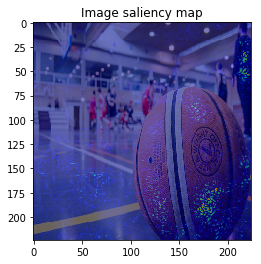

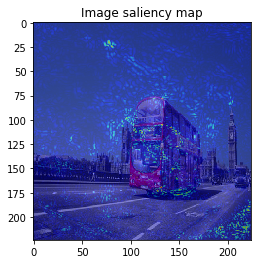

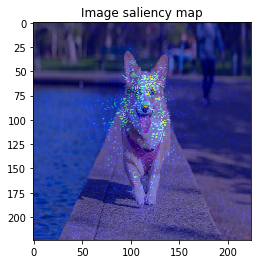

In [46]:
from chainer_chemistry.saliency.visualizer.image_visualizer import ImageVisualizer

visualizer = ImageVisualizer()


for index in range(len(saliency_vanilla)):
    image = imgs[index].resize(saliency_vanilla[index].shape)
    # visualizer.visualize(saliency_vanilla[index], image, show_colorbar=False)
    visualizer.visualize(saliency_vanilla[index], image, show_colorbar=False, save_filepath='results/{:03}_vanilla.png'.format(index))

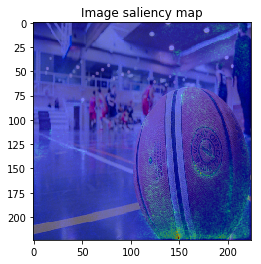

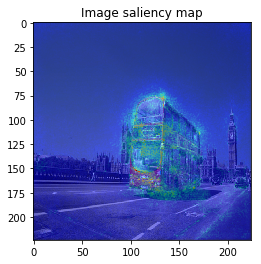

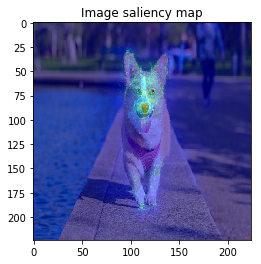

In [47]:
for index in range(len(saliency_vanilla)):
    image = imgs[index].resize(saliency_smooth[index].shape)
    # visualizer.visualize(saliency_smooth[index], image, show_colorbar=False)
    visualizer.visualize(saliency_smooth[index], image, show_colorbar=False, save_filepath='results/{:03}_smooth.png'.format(index))

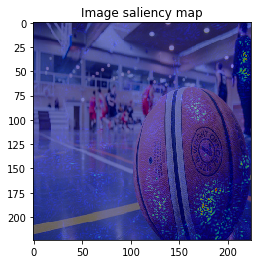

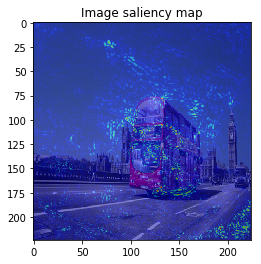

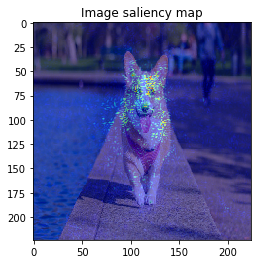

In [48]:
for index in range(len(saliency_vanilla)):
    image = imgs[index].resize(saliency_bayes[index].shape)
    # visualizer.visualize(saliency_bayes[index], image, show_colorbar=False)
    visualizer.visualize(saliency_bayes[index], image, show_colorbar=False, save_filepath='results/{:03}_bayes.png'.format(index))

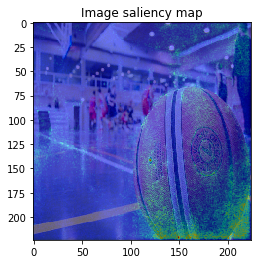

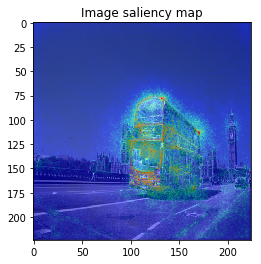

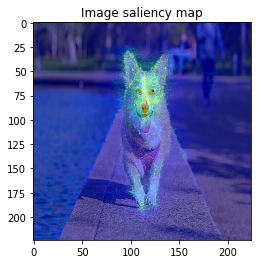

In [49]:
for index in range(len(saliency_vanilla)):
    image = imgs[index].resize(saliency_bayes_smooth[index].shape)
    # visualizer.visualize(saliency_bayes_smooth[index], image, show_colorbar=False)
    visualizer.visualize(saliency_bayes_smooth[index], image, show_colorbar=False, save_filepath='results/{:03}_bayes_smooth.png'.format(index))